<a href="https://colab.research.google.com/github/sgwhat/analytics-zoo/blob/colab-notebook/docs/docs/colab-notebook/orca/examples/super_resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#
# Copyright 2018 Analytics Zoo Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
# This example trains a super-resolution network on the BSD300 dataset,
# using crops from the 200 training images, and evaluating on crops of the 100 test images,
# and is adapted from
# https://github.com/pytorch/examples/tree/master/super_resolution
#

## **Environment Preparation**

**Install Java 8**

Run the cell on the **Google Colab** to install jdk 1.8.

**Note:** if you run this notebook on your computer, root permission is required when running the cell to install Java 8. (You may ignore this cell if Java 8 has already been set up in your computer).

In [ ]:
# Install jdk8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
# Set environment variable JAVA_HOME.
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

**Install Analytics Zoo**

[Conda](https://docs.conda.io/projects/conda/en/latest/user-guide/install/) is needed to prepare the Python environment for running this example. 

**Note**: The following code cell is specific for setting up conda environment on Colab; for general conda installation, please refer to the [install guide](https://docs.conda.io/projects/conda/en/latest/user-guide/install/) for more details.

In [ ]:
import sys

# Get current python version
version_info = sys.version_info
python_version = f"{version_info.major}.{version_info.minor}.{version_info.micro}"

In [ ]:
# Install Miniconda
!wget https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
!chmod +x Miniconda3-4.5.4-Linux-x86_64.sh
!./Miniconda3-4.5.4-Linux-x86_64.sh -b -f -p /usr/local

# Update Conda
!conda install --channel defaults conda python=$python_version --yes
!conda update --channel defaults --all --yes

# Append to the sys.path
_ = (sys.path
        .append(f"/usr/local/lib/python{version_info.major}.{version_info.minor}/site-packages"))

os.environ['PYTHONHOME']="/usr/local"

You can install the latest pre-release version using `pip install --pre  analytics-zoo`.

In [ ]:
# Install latest pre-release version of Analytics Zoo 
# For bigdl backend
!pip install --pre --upgrade analytics-zoo

In [ ]:
# Install torchvision by conda
!pip install tqdm
!conda install pytorch torchvision cpuonly -c pytorch -y

In [ ]:
# Install required dependencies
!pip install pillow
!pip install jep==3.9.0
!pip install cloudpickle
!pip install tensorboardx==2.2
!pip install tb-nightly

## **Distributed Pytorch using Orca APIs**

In this guide we will describe how to scale out PyTorch programs using Orca in 5 simple steps.

In [ ]:
#import necessary libraries and modules
import numpy as np

import urllib
import tarfile
from os import makedirs, remove, listdir
from os.path import exists, join, basename

from zoo.orca import init_orca_context, stop_orca_context
from zoo.orca import OrcaContext

### **Step 1: Init Orca Context**


In [ ]:
# recommended to set it to True when running Analytics Zoo in Jupyter notebook. 
OrcaContext.log_output = True # (this will display terminal's stdout and stderr in the Jupyter notebook).

cluster_mode = "local"

if cluster_mode == "local":
    init_orca_context(cores=1, memory="2g") # run in local mode
elif cluster_mode == "k8s":
    init_orca_context(cluster_mode="k8s", num_nodes=2, cores=4) # run on K8s cluster
elif cluster_mode == "yarn":
    init_orca_context(
        cluster_mode="yarn-client", cores=4, num_nodes=2, memory="2g",
        driver_memory="10g", driver_cores=1,
        conf={"spark.rpc.message.maxSize": "1024",
              "spark.task.maxFailures": "1",
              "spark.driver.extraJavaOptions": "-Dbigdl.failure.retryTimes=1"}) # run on Hadoop YARN cluster

This is the only place where you need to specify local or distributed mode. View [Orca Context](https://analytics-zoo.readthedocs.io/en/latest/doc/Orca/Overview/orca-context.html) for more details.

**Note**: You should export HADOOP_CONF_DIR=/path/to/hadoop/conf/dir when you run on Hadoop YARN cluster.

### **Step 2: Define the Model**
You may define your model, loss and optimizer in the same way as in any standard (single node) PyTorch program.

In [ ]:
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim

class Net(nn.Module):
    def __init__(self, upscale_factor):
        super(Net, self).__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)
        self._initialize_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))
        return x

    def _initialize_weights(self):
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)

torch.manual_seed(123)
net = Net(upscale_factor=3)
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [ ]:
# training parameters
criterion = nn.MSELoss()

epochs = 1
thread = 4
batch_size = 32
test_batch_size = 10

### **Step 3: Define Train Dataset**

**Prepare Dataset**

This is an example using the efficient sub-pixel convolution layer to train on BSDS3000 dataset, using crops from the 200 training images, and evaluating on crops of the 100 test images. 

In [ ]:
# download dataset
def download_report(count, block_size, total_size):
    downloaded = count * block_size
    percent = 100. * downloaded / total_size
    percent = min(100, percent)
    print('downloaded %d, %.2f%% completed' % (downloaded, percent))

def download_bsd300(dest="./dataset"):
    output_image_dir = join(dest, "BSDS300/images")

    if not exists(output_image_dir):
        makedirs(dest)
        url = "http://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz"
        print("downloading url ", url)

        file_path = join(dest, basename(url))
        urllib.request.urlretrieve(url, file_path, download_report)

        print("Extracting data")
        with tarfile.open(file_path) as tar:
            for item in tar:
                tar.extract(item, dest)
        remove(file_path)
    return output_image_dir

# the traning dataset can only be image
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])

Get training image data from download path.

In [ ]:
class DatasetFromFolder(data.Dataset):
    def __init__(self, image_dir, input_transform=None, target_transform=None):
        super(DatasetFromFolder, self).__init__()
        self.image_filenames = [join(image_dir, x)
                                for x in listdir(image_dir) if is_image_file(x)]
        self.input_transform = input_transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        input = load_img(self.image_filenames[index])
        target = input.copy()
        if self.input_transform:
            input = self.input_transform(input)
        if self.target_transform:
            target = self.target_transform(target)
        return input, target

    def __len__(self):
        return len(self.image_filenames)

Preprocess the image dataset and transfer PIL.Image to Tensor. 

In [ ]:
from PIL import Image
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize

def load_img(filepath):
    img = Image.open(filepath).convert('YCbCr')
    y, _, _ = img.split()
    return y

def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)

def input_transform(crop_size, upscale_factor):
    return Compose([
        CenterCrop(crop_size),
        Resize(crop_size // upscale_factor),
        ToTensor(),
    ])

def target_transform(crop_size):
    return Compose([
        CenterCrop(crop_size),
        ToTensor(),
    ])

You can define the train and test dataloader using standarad `torch.utils.data.DataLoader` and put into dataset.

In [ ]:
from torch.utils.data import DataLoader

def get_training_set(upscale_factor):
  root_dir = download_bsd300()
  train_dir = join(root_dir, "train")
  crop_size = calculate_valid_crop_size(256, upscale_factor)
  return DatasetFromFolder(train_dir,
                           input_transform=input_transform(crop_size, upscale_factor),
                           target_transform=target_transform(crop_size))

train_set = get_training_set(upscale_factor=3)
train_loader = DataLoader(dataset=train_set,
                                  batch_size=batch_size,
                                  num_workers=thread,
                                  shuffle=True)

def get_test_set(upscale_factor):
  root_dir = download_bsd300()
  test_dir = join(root_dir, "test")
  crop_size = calculate_valid_crop_size(256, upscale_factor)
  return DatasetFromFolder(test_dir,
                           input_transform=input_transform(crop_size, upscale_factor),
                           target_transform=target_transform(crop_size))

test_set = get_test_set(upscale_factor=3)
test_loader = DataLoader(dataset=test_set,
                                 batch_size=batch_size,
                                 num_workers=thread,
                                 shuffle=False)

### **Step 4: Fit with Orca Estimator**

First, Create an Estimator and set its backend to `bigdl`.

In [ ]:
from zoo.orca.learn.pytorch import Estimator
from zoo.orca.learn.metrics import MSE
from zoo.orca.learn.trigger import EveryEpoch

estimator = Estimator.from_torch(
        model=net,
        optimizer=optimizer,
        loss=criterion,
        metrics=[MSE()],
        backend="bigdl"
    )

# the path of the directory where to save the log files to be parsed by TensorBoard
tensorboard_dir = "runs"
# "bigdl" is the application name for tensorboard to save training and validation results under log path
estimator.set_tensorboard(tensorboard_dir, "bigdl")

Next, fit using the Estimator.

In [ ]:
estimator.fit(data=train_loader, epochs=epochs, validation_data=test_loader, checkpoint_trigger=EveryEpoch())

Finally, evaluate using the Estimator.

In [ ]:
from math import log10
# PSNR is Peak Signal to Noise Ratio, we convert maximize PSNR to minimize MSE
val_stats = estimator.evaluate(data=test_loader)
print("===> Validation Complete: Avg. PSNR: {:.4f} dB, Avg. Loss: {:.4f}"
          .format(10 * log10(1. / val_stats["MSE"]), val_stats["MSE"]))

The PSNR of this model has reached around 11dB.



In [ ]:
# Stop orca context when your program finishes
stop_orca_context()

### **Step 5: Visualization by Tensorboard**

TensorBoard is a visualization toolkit for machine learning experimentation. TensorBoard allows tracking and visualizing metrics such as loss and accuracy, visualizing the model graph, viewing histograms, displaying images and much more.

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import matplotlib.pyplot as plt

# helper function to show an image
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

Reach the testing image and apply model to fit.

In [28]:
import torchvision

# plot one random training image
img_to_tensor = ToTensor()

# input testing image and convert to tensor
img = Image.open('dataset/BSDS300/images/test/16077.jpg').convert('YCbCr')
y, cb, cr = img.split()
test_image = img_to_tensor(y).view(1, -1, y.size[1], y.size[0])

# output image after model training and conver to tensor
out = net(test_image).cpu()
out_img_y = out[0].detach().numpy()
out_img_y *= 255.0
out_img_y = out_img_y.clip(0, 255)
out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')

out_img_cb = cb.resize(out_img_y.size, Image.BILINEAR)
out_img_cr = cr.resize(out_img_y.size, Image.BILINEAR)
out_img = Image.merge('YCbCr', [out_img_y, out_img_cb, out_img_cr]).convert('RGB')
out_image = img_to_tensor(out_img_y).view(1, -1, out_img_y.size[1], out_img_y.size[0])

# create grid of images
test_image_grid = torchvision.utils.make_grid(test_image)
out_image_grid = torchvision.utils.make_grid(out_image)

Show the testing and output image.

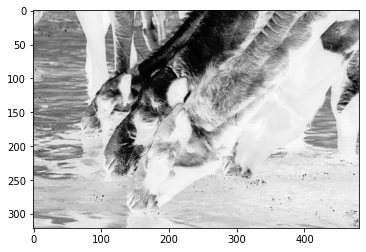

In [29]:
# show testing image
matplotlib_imshow(test_image_grid, one_channel=True)

In [ ]:
# show output image
matplotlib_imshow(out_image_grid, one_channel=True)

A brief overview of the dashboards shown (tabs in top navigation bar):

* The **SCALARS** dashboard shows how the loss and metrics change with every epoch. You can use it to also track training speed, learning rate, and other scalar values.
* The **IMAGES** dashboard can  be extremely helpful to sample and examine your input data, or to visualize layer weights and generated tensors. 
* The **GRAPHS** dashboard helps you visualize your model. In this case, the graph of layers is shown which can help you ensure it is built correctly.


In [ ]:
from tensorboardX import SummaryWriter

tensorboard_dir = "runs"
writer = SummaryWriter(tensorboard_dir + '/bigdl/train')

# write to tensorboard
writer.add_image('output_image', out_image_grid)
writer.add_image('test_image', test_image_grid) 

# plot some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# inspect the model using tensorboard
writer.add_graph(net, images)

If you do not need the summary writer anymore, call close() method.

In [ ]:
writer.close()

Start TensorBoard, specifying the root log directory you used above. 
Argument ``logdir`` points to directory where TensorBoard will look to find 
event files that it can display. TensorBoard will recursively walk 
the directory structure rooted at logdir, looking for .*tfevents.* files.
This dashboard shows how the loss and accuracy change with every iteration.

In [ ]:
%tensorboard --logdir "/content/runs/bigdl/train"